# Homework 4

In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/IndraniMandal/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


 ## Loading Data

In [2]:
import pandas as pd, numpy as np
# import csv as a pandas dataframe
covid_df = pd.read_csv('https://raw.githubusercontent.com/IndraniMandal/CSC310-S20/master/messy_covid19_southamerica%20-%20covid19_southamerica.csv')

In [3]:
covid_df.head()

,ObservationDate,Country_Region,Province_State,Confirmed,Deaths,Recovered,Active
0,2020-01-23,Mexico,NaN,0.0,0,0,0.0
1,2020-01-23,Brazil,NaN,0.0,0,0,0.0
2,2020-01-23,Colombia,NaN,0.0,0,0,0.0
3,2020-02-26,Brazil,NaN,1.0,0,0,1.0
4,2020-02-26,Brazil,NaN,1.0,0,0,1.0


## Search for Missing Data

We can see that there's a very large number of missing entries for the province/state of a particular row, as well as some minor missing pieces of data for categories like confirmed, deaths, recovered, and active.

In [4]:
covid_df.isnull().sum()

ObservationDate       0
Country_Region        0
Province_State     5989
Confirmed             1
Deaths                3
Recovered             2
Active               26
dtype: int64

In [5]:
total_num = covid_df['Province_State'].count()
missing_num = covid_df['Province_State'].isnull().sum()
pct_missing = missing_num / total_num * 100
print('There are {} missing entries, or {:.2f}% of all {} entries.'.format(missing_num, pct_missing, total_num))

There are 5989 missing entries, or 34.90% of all 17161 entries.


Since such a large percentage of the total entries are missing, it probably makes sense to drop this column entirely. On the other hand, the confirmed, deaths, recovered, and active columns are missing so few values that they still have relevant info in over 99% of entries, so these should be kept.

In [6]:
for col in covid_df.columns:
  total = covid_df[col].count()
  missing = covid_df[col].isnull().sum()
  pct = missing / total * 100
  print('There are {} missing entries in the {} column, or {:.2f}% of all {} entries.'.format(missing, col, pct, total))

clean_covid_df = covid_df.drop(columns = 'Province_State', axis = 1)

There are 0 missing entries in the ObservationDate column, or 0.00% of all 23150 entries.
There are 0 missing entries in the Country_Region column, or 0.00% of all 23150 entries.
There are 5989 missing entries in the Province_State column, or 34.90% of all 17161 entries.
There are 1 missing entries in the Confirmed column, or 0.00% of all 23149 entries.
There are 3 missing entries in the Deaths column, or 0.01% of all 23147 entries.
There are 2 missing entries in the Recovered column, or 0.01% of all 23148 entries.
There are 26 missing entries in the Active column, or 0.11% of all 23124 entries.


Deciding what to do with the missing values will depend on what you're trying to accomplish with the data.
Imputation is an option, for example:
 - Empty values in the Deaths column are likely to indicate no deaths on a given day, hence no value reported.
 - On the other hand, missing values in confirmed, recovered, or active columns should probably be filled in either by finding an average or imputing using the k nearest neighbors, since it's highly unlikely that these values just dropped to 0 on a given day.  
  
Another option for the columns missing less than 1% of their data is to just delete the rows where these values are missing. We don't lose a significant amount of data doing this and don't have to make any assumptions.

In [7]:
clean_covid_df['Deaths'].fillna(0, inplace = True)
clean_covid_df.Deaths[clean_covid_df.Deaths.isnull()]

Series([], Name: Deaths, dtype: object)

Once the Province_State column is gone, the rest of the nonsense values can be removed and we'll lose less than 30 values, so just dropping incomplete rows is good enough for our evaluation.

In [8]:
clean_covid_df.dropna(inplace = True)

The countries with the highest confirmed case counts can be found by sorting in descending order.

In [9]:
top_confirmed = clean_covid_df.sort_values(by = 'Confirmed', ascending = False)
top_confirmed

,ObservationDate,Country_Region,Confirmed,Deaths,Recovered,Active
23016,2020-09-28,Brazil,973142.0,35125,839142,98875.0
22852,2020-09-27,Brazil,972237.0,35108,831568,105561.0
22688,2020-09-26,Brazil,970888.0,35063,823720,112105.0
22524,2020-09-25,Brazil,964921.0,34877,821045,108999.0
22360,2020-09-24,Brazil,958240.0,34677,821045,102518.0
...,...,...,...,...,...,...
9904,2020-07-02,Chile,0.0,0,109,-109.0
9868,2020-07-07,Peru,0.0,0,200938,-200938.0
13840,2020-07-16,Colombia,0.0,0,0,0.0
9867,2020-07-07,Colombia,0.0,0,0,0.0


Then we can create a list of the individual countries by sorting for unique values. We'll use this later to create a data frame.

In [10]:
countries = top_confirmed.Country_Region.unique()
countries

array(['Brazil', 'Argentina', 'Peru', 'Chile', 'Colombia', 'Ecuador',
       'Bolivia', 'Mexico', 'Dominican Republic', 'Panama', 'Guatemala',
       'Honduras', 'Costa Rica', 'Venezuela', 'Paraguay', 'El Salvador',
       'Haiti', 'Jamaica', 'Cuba', 'Nicaragua', 'Suriname',
       'Trinidad and Tobago', 'Bahamas', 'Guyana', 'Uruguay', 'Belize',
       'Barbados', 'Antigua and Barbuda',
       'Saint Vincent and the Grenadines', 'Guadeloupe', 'Martinique',
       'Dominica', 'Saint Lucia', 'Grenada', 'Saint Kitts and Nevis',
       'French Guiana', 'Saint Barthelemy'], dtype=object)

Then we can find the peak number of confirmed cases from each country to find out which had reached the highest cases within a day.

In [11]:
max_confirmed = []
for country in countries:
  max_confirmed.append(clean_covid_df[clean_covid_df.Country_Region == country].Confirmed.max())
max_confirmed

[973142.0,
 723132.0,
 367068.0,
 285939.0,
 265576.0,
 134965.0,
 134223.0,
 124314.0,
 111666.0,
 111277.0,
 90263.0,
 75537.0,
 73714.0,
 73528.0,
 39432.0,
 28809.0,
 8740.0,
 6170.0,
 5483.0,
 5073.0,
 4836.0,
 4386.0,
 3838.0,
 2787.0,
 2010.0,
 1891.0,
 190.0,
 101.0,
 64.0,
 53.0,
 32.0,
 30.0,
 27.0,
 24.0,
 19.0,
 18.0,
 3.0]

Next, we create a dataframe from the countries and their maximum values.

In [12]:
df = pd.DataFrame([countries, max_confirmed])
df

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
0,Brazil,Argentina,Peru,Chile,Colombia,Ecuador,Bolivia,Mexico,Dominican Republic,Panama,...,Antigua and Barbuda,Saint Vincent and the Grenadines,Guadeloupe,Martinique,Dominica,Saint Lucia,Grenada,Saint Kitts and Nevis,French Guiana,Saint Barthelemy
1,973142.0,723132.0,367068.0,285939.0,265576.0,134965.0,134223.0,124314.0,111666.0,111277.0,...,101.0,64.0,53.0,32.0,30.0,27.0,24.0,19.0,18.0,3.0


We need to transpose this dataframe, since we would rather the data frame have columns 'Countries' and 'Max Cases'.

In [13]:
df = df.T
df.columns = ['Country_Region', 'Confirmed']
df = df.set_index('Country_Region')
df

,Confirmed
Country_Region,
Brazil,973142.0
Argentina,723132.0
Peru,367068.0
Chile,285939.0
Colombia,265576.0
Ecuador,134965.0
Bolivia,134223.0
Mexico,124314.0
Dominican Republic,111666.0


The countries can be plotted for a nice visual, but this graph probably includes too many data points.

<Axes: xlabel='Country_Region'>

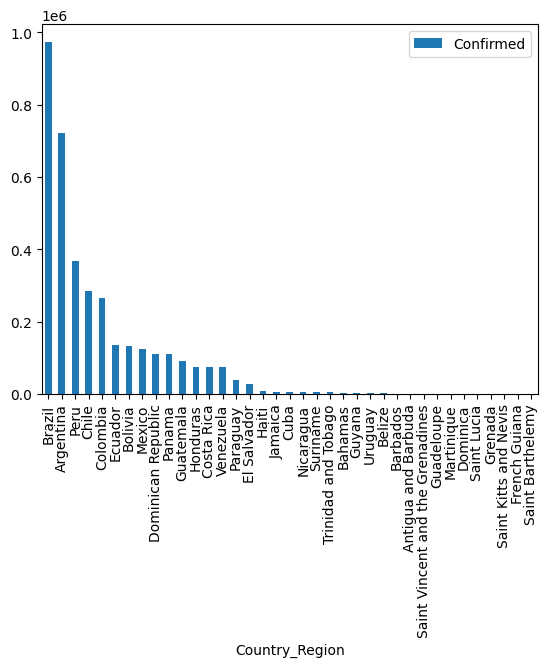

In [14]:
df.plot(kind = 'bar')

Instead, the top ten countries can be grouped into a new dataframe in order to create a graph that's better for inspecting the details of the top countries' case counts.

<Axes: xlabel='Country_Region'>

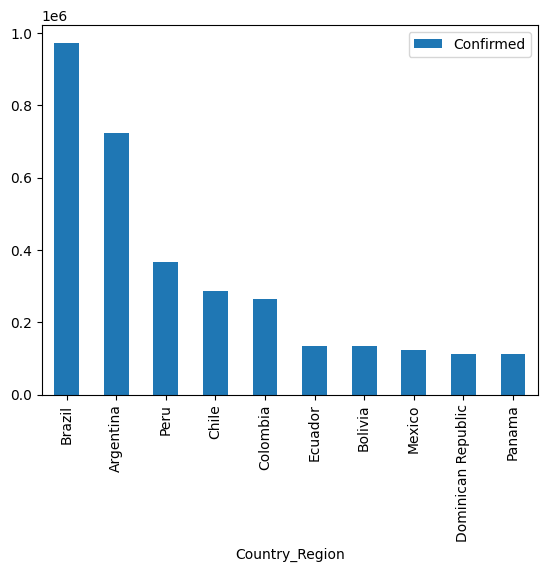

In [17]:
df_top10 = df.head(10)
df_top10.plot(kind = 'bar')